In [1]:
# %matplotlib widget

In [2]:
from pathlib import Path

import torch

import numpy as np
import nibabel as nib
from skimage.color import label2rgb
import matplotlib.pyplot as plt

from niftynet.io.image_reader import ImageReader
from niftynet.utilities.util_common import ParserNamespace
from niftynet.io.image_sets_partitioner import ImageSetsPartitioner
from niftynet.layer.histogram_normalisation import (
    HistogramNormalisationLayer,
)
from niftynet.layer.binary_masking import (
    BinaryMaskingLayer,
)

from highresnet import HighRes3DNet

INFO:tensorflow:TensorFlow version 1.10.0
CRITICAL:tensorflow:Optional Python module cv2 not found, please install cv2 and retry if the application fails.
CRITICAL:tensorflow:Optional Python module SimpleITK not found, please install SimpleITK and retry if the application fails.
INFO:tensorflow:Available Image Loaders:
['nibabel', 'skimage', 'pillow', 'dummy'].
INFO:niftynet: Optional Python module yaml not found, please install yaml and retry if the application fails.
INFO:niftynet: Optional Python module yaml version None not found, please install yaml-None and retry if the application fails.
INFO:niftynet: Optional Python module SimpleITK not found, please install SimpleITK and retry if the application fails.
INFO:niftynet: Optional Python module SimpleITK version None not found, please install SimpleITK-None and retry if the application fails.


In [3]:
state_dict_pt_path = '/tmp/state_dict_pt.pth'

## Standardisation

In [4]:
def preprocess(input_path,
               model_path,
               output_path,
               cutoff,
    ):
    input_path = Path(input_path)
    output_path = Path(output_path)
    input_dir = input_path.parent
    
    DATA_PARAM = {
        'Modality0': ParserNamespace(
            path_to_search=str(input_dir),
            filename_contains=('nii.gz',),
            interp_order=0,
            pixdim=None,
            axcodes='RAS',
            loader=None,
        )
    }

    TASK_PARAM = ParserNamespace(image=('Modality0',))
    data_partitioner = ImageSetsPartitioner()
    file_list = data_partitioner.initialise(DATA_PARAM).get_file_list()
    reader = ImageReader(['image'])
    reader.initialise(DATA_PARAM, TASK_PARAM, file_list)
    
    binary_masking_func = BinaryMaskingLayer(
        type_str='mean_plus',
    )
    
    hist_norm = HistogramNormalisationLayer(
        image_name='image',
        modalities=['Modality0'],
        model_filename=str(model_path),
        binary_masking_func=binary_masking_func,
        cutoff=cutoff,
        name='hist_norm_layer',
    )
    
    image = reader.output_list[0]['image']
    data = image.get_data()
    norm_image_dict, mask_dict = hist_norm({'image': data})
    data = norm_image_dict['image']
    nii = nib.Nifti1Image(data.squeeze(), image.original_affine[0])
    dst = output_path
    nii.to_filename(str(dst))

input_path = '/tmp/pt/reoriented/reoriented.nii.gz'
model_path = '/home/fernando/niftynet/models/highres3dnet_brain_parcellation/databrain_std_hist_models_otsu.txt'
output_path = Path('/tmp/hist.nii.gz')
cutoff = (0.001, 0.999)  # from .ini
preprocess(input_path, model_path, output_path, cutoff)

INFO:niftynet: 

Number of subjects 1, input section names: ['subject_id', 'Modality0']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 1 subjects from sections ('Modality0',) as input [image]


## Whitening

In [5]:
nii = nib.load(str(output_path))
data = nii.get_data()
fg_only = True  # NN default is True
if fg_only:
    mask = data > data.mean()
    values = data[mask]
else:
    values = data
data -= values.mean()
data /= values.std()

In [6]:
def turn(s):
    return np.fliplr(np.rot90(s))

def plot_volume(array):
    fig, axes = plt.subplots(1, 3)
    si, sj, sk = array.shape[:3]
    if array.ndim == 3:
        axes[0].imshow(turn(array[si//2, ...]), cmap='gray')
        axes[1].imshow(turn(array[:, sj//2, :]), cmap='gray')
        axes[2].imshow(turn(array[..., sk//2]), cmap='gray')
    else:
        axes[0].imshow(turn(array[si//2, ...]))
        axes[1].imshow(turn(array[:, sj//2, ...]))
        axes[2].imshow(turn(array[..., sk//2, :]))
    plt.tight_layout()

In [7]:
# plot_volume(data)
size = 24
center = np.array((80, 116, 128))
center = np.array((120, 116, 128))
ini = center - size // 2
fin = ini + size
roi = data[ini[0]:fin[0], ini[1]:fin[1], ini[2]:fin[2]]

# # Save ROI
# roi_nii = nib.Nifti1Image(roi, np.eye(4))  # origin will be wrong
# # p = Path('/tmp/pt/roi/roi.nii.gz')
# p = Path('/tmp/pt/tiny/tiny.nii.gz')
# p.parent.mkdir(exist_ok=True)
# roi_nii.to_filename(str(p))

# plot_volume(roi)
# plt.show()

In [8]:
# torch.manual_seed(42)
# TINY_SIZE = 24
# shape = TINY_SIZE, TINY_SIZE, TINY_SIZE
# roi = np.random.rand(*shape).astype(np.float32)  # minimum size for dilation factor 4
# roi_nii = nib.Nifti1Image(roi, np.eye(4))  # origin will be wrong
# p = Path('/tmp/pt/tiny/tiny.nii.gz')
# p.parent.mkdir(exist_ok=True)
# roi_nii.to_filename(str(p))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict_pt = torch.load(state_dict_pt_path)
model = HighRes3DNet(1, 160, add_dropout_layer=True, softmax=False)
model.load_state_dict(state_dict_pt)
model = model.to(device)
tensor = torch.tensor(roi)
tensor = tensor.unsqueeze(0)  # channels dimension
batch = tensor.unsqueeze(0)  # batch dimension
batch = batch.to(device)

print('Input:', batch.shape)
model.eval()
with torch.no_grad():
    outputs = model(batch)
for i, output in enumerate(outputs):
    print(f'Output {i}:', output.shape)

Input: torch.Size([1, 1, 24, 24, 24])
Output 0: torch.Size([1, 16, 24, 24, 24])
Output 1: torch.Size([1, 16, 24, 24, 24])
Output 2: torch.Size([1, 16, 24, 24, 24])
Output 3: torch.Size([1, 16, 24, 24, 24])
Output 4: torch.Size([1, 32, 24, 24, 24])
Output 5: torch.Size([1, 32, 24, 24, 24])
Output 6: torch.Size([1, 32, 24, 24, 24])
Output 7: torch.Size([1, 64, 24, 24, 24])
Output 8: torch.Size([1, 64, 24, 24, 24])
Output 9: torch.Size([1, 64, 24, 24, 24])
Output 10: torch.Size([1, 80, 24, 24, 24])
Output 11: torch.Size([1, 80, 24, 24, 24])
Output 12: torch.Size([1, 160, 24, 24, 24])


In [10]:
output_dir = Path('/tmp/activations_pt')
for layer, output in enumerate(outputs):
    array = output.squeeze().cpu().numpy()
    layer_dir = output_dir / f'layer_{layer}'
    layer_dir.mkdir(exist_ok=True, parents=True)
    num_features = array.shape[0]
    for feature_idx in range(num_features):
        features = array[feature_idx, ...]
        filename = f'feature_{feature_idx}.nii.gz'
        filepath = layer_dir / filename
        nib.Nifti1Image(features, np.eye(4)).to_filename(str(filepath))

/tmp/activations_tf/layer_11/feature_0.nii.gz (24, 24, 24)
/tmp/activations_pt/layer_12/feature_0.nii.gz (24, 24, 24)
Diff feature 0: 3.4300144e-06

/tmp/activations_tf/layer_11/feature_1.nii.gz (24, 24, 24)
/tmp/activations_pt/layer_12/feature_1.nii.gz (24, 24, 24)
Diff feature 1: 1.9133258e-06

/tmp/activations_tf/layer_11/feature_2.nii.gz (24, 24, 24)
/tmp/activations_pt/layer_12/feature_2.nii.gz (24, 24, 24)
Diff feature 2: 1.8519509e-06

/tmp/activations_tf/layer_11/feature_3.nii.gz (24, 24, 24)
/tmp/activations_pt/layer_12/feature_3.nii.gz (24, 24, 24)
Diff feature 3: 2.2438755e-06

/tmp/activations_tf/layer_11/feature_4.nii.gz (24, 24, 24)
/tmp/activations_pt/layer_12/feature_4.nii.gz (24, 24, 24)
Diff feature 4: 1.9006286e-06

/tmp/activations_tf/layer_11/feature_5.nii.gz (24, 24, 24)
/tmp/activations_pt/layer_12/feature_5.nii.gz (24, 24, 24)
Diff feature 5: 1.5966704e-06

/tmp/activations_tf/layer_11/feature_6.nii.gz (24, 24, 24)
/tmp/activations_pt/layer_12/feature_6.nii.gz (

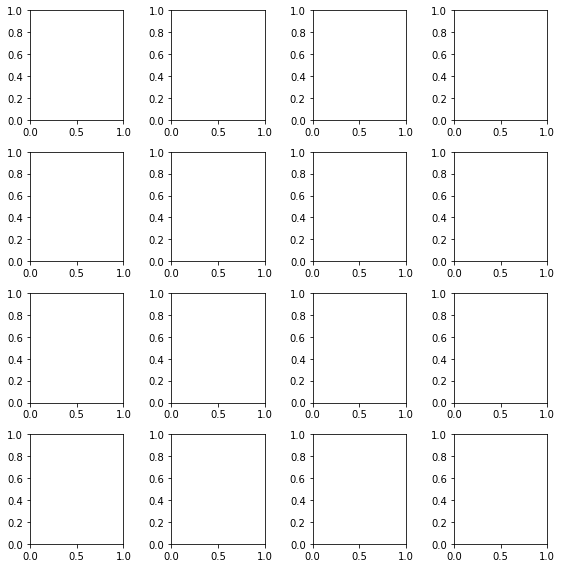

In [13]:
# tf_to_pt = {
#     0: 0,
#     3: 1,
#     4: 
#     6: 2,
#     9: 3,
#     10: 4,
#     11: 6,
# }

layer_idx_tf = 11
# layer_idx_pt = tf_to_pt[layer_idx_tf]
layer_idx_pt = 12

layer_dir_tf = Path(f'/tmp/activations_tf/layer_{layer_idx_tf}')
layer_dir_pt = Path(f'/tmp/activations_pt/layer_{layer_idx_pt}')

plot_diff = False


k = 7
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.ravel()
for i in range(160):
    filepath_tf = layer_dir_tf / f'feature_{i}.nii.gz'
    filepath_pt = layer_dir_pt / f'feature_{i}.nii.gz'
    nii_tf = nib.load(str(filepath_tf))
    nii_pt = nib.load(str(filepath_pt))
    print(filepath_tf, nii_tf.shape)
    print(filepath_pt, nii_pt.shape)
#     print(nii_tf.get_data().sum())
#     print(nii_pt.get_data().sum())
    slice_tf = turn(nii_tf.dataobj[..., k])
    slice_pt = turn(nii_pt.dataobj[..., k])
#     ax = axes[i]
#     if plot_diff:
#         diff = slice_tf - slice_pt
#         max_diff = np.max(np.abs(diff))
#         im = ax.imshow(diff, cmap='RdBu_r', vmin=-max_diff, vmax=max_diff)
#         fig.colorbar(im, ax=ax)
#     else:
#         result = np.hstack((slice_tf, slice_pt))
#         im = ax.imshow(result)
    rms = np.sqrt(np.mean(np.square(slice_tf - slice_pt)))
    print(f'Diff feature {i}:', rms)
    print()
plt.tight_layout()
plt.show()

In [ ]:
data_tf = nib.load(f'/tmp/activations_tf/layer_{layer_idx_tf}/feature_{i}.nii.gz').get_data()
data_pt = nib.load(f'/tmp/activations_pt/layer_{layer_idx_pt}/feature_{i}.nii.gz').get_data()

fig, axes = plt.subplots(1, 2)
axes[0].hist(data_tf.ravel(), bins=50)
axes[1].hist(data_pt.ravel(), bins=50)
plt.tight_layout()
plt.show()


In [ ]:
labels = outputs.argmax(dim=1).squeeze().cpu().numpy()
output_array = output.squeeze().cpu().numpy()
nib.Nifti1Image(output_array[0, ...], np.eye(4)).to_filename('/tmp/activation_pt.nii.gz')
image_label_overlay = label2rgb(labels)
plot_volume(roi)
plot_volume(output_array[0, ...])
plot_volume(image_label_overlay)

In [ ]:
# label_map = np.zeros_like(data, dtype=np.uint16)
# label_map[ini[0]:fin[0], ini[1]:fin[1], ini[2]:fin[2]] = labels
# label_nii = nib.Nifti1Image(label_map, roi_nii.affine)  # origin like ROI
# label_nii.to_filename('/tmp/labels.nii.gz')